In [28]:
import pandas as pd
import requests
import os
from datetime import datetime
from data_creation import download_ecallisto_files, LOCAL_DATA_FOLDER
from glob import glob
from radiospectra.sources import CallistoSpectrogram
from spectogram_utils import spec_to_pd_dataframe, plot_spectogram, masked_spectogram_to_array
from database_utils import extract_instrument_name, glob_files, extract_constant_meta_data, extract_separate_instruments, create_dict_of_instrument_paths

In [29]:
from database_functions import *
from database_utils import *
import numpy as np
from tqdm import tqdm

In [30]:
def combine_non_unique_frequency_axis(spec, method="mean"):
    """Combine non-unique frequency axis data.

    Parameters
    ----------
    spec : `~radiospectra.spectrogram.Spectrogram`
        The spectrogram to combine the frequency axis data of.
    method : str, optional
        The method to use to combine the frequency axis data. Defaults to "mean".

    Returns
    -------
    `~radiospectra.spectrogram.Spectrogram`
        The spectrogram with combined frequency axis data.

    Notes
    -----
    The function first finds the unique frequency axis data and the indices of the non-unique frequency axis data.
    It then combines the non-unique frequency axis data using the method specified by the `method` parameter.
    """
    unique_freq_axis, indices = np.unique(spec.freq_axis, return_inverse=True)
    if method == "mean":
        data = np.array(
            [
                np.mean(spec.data[indices == i], axis=0)
                for i in range(len(unique_freq_axis))
            ]
        )
    else:
        raise ValueError(f"Method {method} not supported")
    spec.data = data
    spec.freq_axis = unique_freq_axis

    return spec

In [31]:
test = glob_files(LOCAL_DATA_FOLDER, datetime(2023, 1, 25).date(), datetime(2023, 2, 8).date())

In [ ]:
def add_values_to_database(dict_paths):
    """
    Adds the values from the given dictionary to the given dataframe
    """
    t = tqdm(dict_paths, total=len(dict_paths))
    for instrument in t:
        if instrument not in get_table_names_sql():
            spec = CallistoSpectrogram.read(dict_paths[instrument][0])
            spec = masked_spectogram_to_array(spec)
            if not np.unique(spec.freq_axis).size == len(spec.freq_axis):
                print(f"Warning: {instrument} has non-unique frequency axis")
            sql_columns = numbers_list_to_postgresql_columns_meta_data(spec.freq_axis, 'SMALLINT')
            create_table_datetime_primary_key_sql(instrument, sql_columns, 'datetime')
            table_to_hyper_table(instrument, 'datetime')
        for path in dict_paths[instrument]:
            t.set_description(f"Currently adding {path.split('/')[-1]}")
            spec = CallistoSpectrogram.read(path)
            spec = masked_spectogram_to_array(spec)

            sql_columns = ",".join(number_list_to_postgresql_compatible_list(spec.freq_axis))
            sql_columns = 'datetime,' + sql_columns
            data = np.array(spec.data, dtype=np.int16)
            assert np.all(data <= 32767)
            date_range = spec_time_to_pd_datetime(spec)
            sql_values = np_array_to_postgresql_array_with_datetime_index(date_range, data)
            insert_values_sql(instrument, sql_columns, sql_values)

add_values_to_database(dict_paths)

Currently adding INDIA-UDAIPUR_20230201_110001_01.fit.gz:  89%|████████▉ | 65/73 [03:05<00:22,  2.85s/it]      


DuplicateColumn: column "86.81300354003906" specified more than once


In [ ]:
dict_paths.keys()

dict_keys(['india_ooty_02', 'ssrt_59', 'roswell_nm_57', 'poland_grotniki_03', 'egypt_alexandria_01', 'usa_arizona_erau_01', 'malaysia_banting_01', 'mexico_lance_a_63', 'spain_siguenza_02', 'germany_dlr_62', 'mexico_lance_b_62', 'egypt_alexandria_02', 'australia_lmro_59', 'india_gauri_59', 'australia_assa_60', 'romania_01', 'almaty_58', 'swiss_hb9sct_01', 'bir_01', 'alaska_haarp_62', 'glasgow_01', 'mrt1_02', 'alaska_cohoe_62', 'arecibo_observatory_62', 'australia_assa_63', 'norway_ny_aalesund_01', 'alaska_cohoe_63', 'humain_59', 'germany_dlr_63', 'germany_dlr_01', 'india_ooty_01', 'spain_peralejos_03', 'mongolia_ub_01', 'austria_oe3flb_55', 'triest_60', 'swiss_irsol_01', 'spain_peralejos_62', 'mro_62', 'alaska_haarp_63', 'roswell_nm_59', 'triest_59', 'spain_peralejos_63', 'algeria_craag_59', 'swiss_muhen_62', 'mrt3_03', 'norway_egersund_01', 'roswell_nm_58', 'japan_ibaraki_59', 'austria_oe3flb_57', 'mro_59', 'alaska_anchorage_01', 'hurbanovo_59', 'norway_randaberg_01', 'arecibo_observat

In [ ]:
spec = CallistoSpectrogram.read(dict_paths['indonesia_59'][0])

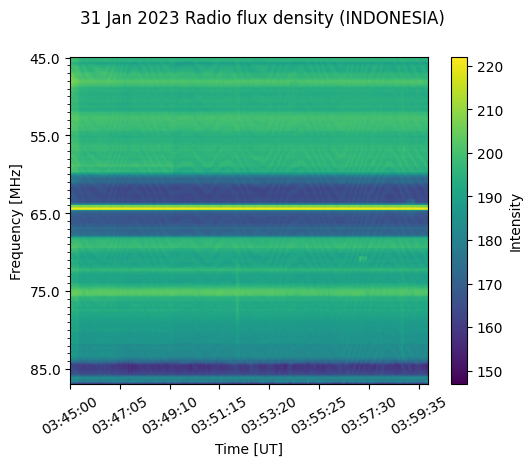

<AxesSubplot: xlabel='Time [UT]', ylabel='Frequency [MHz]'>

In [ ]:
spec.peek()

In [ ]:
def get_values_from_database_sql(table, start_time, end_time, columns=None):
    """
    Returns the values from the given table between the given start and end time
    """
    if columns is None:
        columns = '*'
    
    with psycopg2.connect(CONNECTION) as conn:
        with conn.cursor() as cur:
            cur.execute(f"SELECT {columns} FROM {table} WHERE datetime BETWEEN '{start_time}' AND '{end_time}'")
            return cur.fetchall()
        
def get_column_names_from_table_sql(table):
    """
    Returns the column names from the given table
    """
    with psycopg2.connect(CONNECTION) as conn:
        with conn.cursor() as cur:
            cur.execute(f"SELECT * FROM {table} LIMIT 0")
            columns = [desc[0] for desc in cur.description]
            return columns
        
def sql_result_to_df(result, columns, meta_data:dict=None):
    """
    Converts the given result from a sql query to a pandas dataframe
    """
    df = pd.DataFrame(result, columns=columns)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.set_index('datetime')
    if meta_data:
        for key, value in meta_data.items():
            df.attrs[key] = value
    return df
    
def is_float(element) -> bool:
    #If you expect None to be passed:
    if element is None: 
        return False
    try:
        float(element)
        return True
    except ValueError:
        return False

def to_float_if_possible(element):
    if is_float(element):
        return float(element)
    else:
        return element
    
def timebucket_values_from_database_sql(table, start_time, end_time, columns=None, timebucket='1H', agg_function='avg'):
    """
    Returns all values between start and end time in the given table, timebucketed and aggregated.
    """
    if not columns:
        columns = get_column_names_from_table_sql(table)
        columns = [column for column in columns if column != 'datetime']
        columns = columns[0:99]
    agg_function_sql = ','.join([f'{agg_function}({column})' for column in columns])
    columns = number_list_to_postgresql_compatible_list(columns)
    columns = ','.join(columns)
    print(columns)
    with psycopg2.connect(CONNECTION) as conn:
        with conn.cursor() as cur:
            if columns is None:
                columns = '*'
            cur.execute(f"SELECT time_bucket('{timebucket}', datetime) AS time, avg(\"{164.93800354003906}\") FROM {table} WHERE datetime BETWEEN '{start_time}' AND '{end_time}' GROUP BY time ORDER BY time")
            return cur.fetchall()

In [ ]:
data = timebucket_values_from_database_sql('india_ooty_02', '2023-02-01 02:30:00', '2023-02-01 03:30:00', timebucket='1m', agg_function='avg')

"164.93800354003906","164.31300354003906","163.68800354003906","163.06300354003906","162.43800354003906","161.81300354003906","161.18800354003906","160.56300354003906","159.93800354003906","159.31300354003906","158.68800354003906","158.06300354003906","157.43800354003906","156.81300354003906","156.18800354003906","155.56300354003906","154.93800354003906","154.31300354003906","153.68800354003906","153.06300354003906","152.43800354003906","151.81300354003906","151.18800354003906","150.56300354003906","149.93800354003906","149.31300354003906","148.68800354003906","148.06300354003906","147.43800354003906","146.81300354003906","146.18800354003906","145.56300354003906","144.93800354003906","144.31300354003906","143.68800354003906","143.06300354003906","142.43800354003906","141.81300354003906","141.18800354003906","140.56300354003906","139.93800354003906","139.31300354003906","138.68800354003906","138.06300354003906","137.43800354003906","136.81300354003906","136.18800354003906","135.56300354

In [ ]:
pd.DataFrame(data)

,0,1
0,2023-02-01 02:30:00,140.6820083682008368
1,2023-02-01 02:31:00,140.3291666666666667
2,2023-02-01 02:32:00,140.4083333333333333
3,2023-02-01 02:33:00,140.9416666666666667
4,2023-02-01 02:34:00,140.9125000000000000
5,2023-02-01 02:35:00,141.0000000000000000
6,2023-02-01 02:36:00,140.8875000000000000
7,2023-02-01 02:37:00,140.9333333333333333
8,2023-02-01 02:38:00,140.8333333333333333
9,2023-02-01 02:39:00,140.7125000000000000


In [ ]:
data = get_values_from_database_sql('india_ooty_02', '2023-02-01 02:30:00', '2023-02-01 03:30:00')
columns = get_column_names_from_table_sql('india_ooty_02')
columns = [to_float_if_possible(column) for column in columns]

In [ ]:
data_new = pd.DataFrame(data, index=pd.to_datetime([row[0] for row in data]))
data_new.resample('1min').mean()

/tmp/ipykernel_13571/2061742066.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_new.resample('1min').mean()


,1,2,3,4,5,6,7,8,9,10,...,184,185,186,187,188,189,190,191,192,193
2023-02-01 02:30:00,140.682008,143.836820,150.347280,174.230126,150.171548,140.866109,140.635983,140.117155,139.418410,138.217573,...,168.523013,170.585774,172.531381,174.970711,177.489540,179.728033,178.012552,172.192469,173.343096,160.497908
2023-02-01 02:31:00,140.329167,142.216667,143.112500,146.975000,142.833333,142.633333,142.550000,140.291667,139.516667,138.362500,...,168.604167,170.725000,172.712500,175.100000,177.704167,179.887500,178.016667,172.233333,173.312500,160.104167
2023-02-01 02:32:00,140.408333,142.729167,145.979167,158.083333,146.012500,141.362500,141.079167,140.345833,139.533333,138.429167,...,168.633333,170.745833,172.770833,175.054167,177.625000,179.795833,177.991667,172.370833,173.337500,160.312500
2023-02-01 02:33:00,140.941667,145.320833,156.383333,196.500000,160.020833,140.295833,140.541667,140.116667,139.429167,138.250000,...,168.600000,170.720833,172.679167,175.162500,177.633333,179.895833,177.962500,172.229167,173.295833,160.929167
2023-02-01 02:34:00,140.912500,144.912500,155.700000,193.987500,159.966667,140.233333,140.420833,140.100000,139.441667,138.279167,...,168.587500,170.770833,172.787500,175.162500,177.725000,179.816667,177.916667,172.233333,173.362500,160.870833
2023-02-01 02:35:00,141.000000,145.600000,157.166667,200.054167,160.545833,140.037500,140.579167,140.020833,139.370833,138.229167,...,168.591667,170.720833,172.741667,175.158333,177.775000,179.920833,178.033333,172.341667,173.379167,160.987500
2023-02-01 02:36:00,140.887500,144.983333,155.758333,194.729167,159.495833,140.350000,140.616667,140.075000,139.404167,138.195833,...,168.608333,170.783333,172.850000,175.216667,177.875000,179.970833,178.062500,172.237500,173.458333,160.837500
2023-02-01 02:37:00,140.933333,145.212500,155.812500,195.287500,158.583333,140.008333,140.308333,139.958333,139.320833,138.112500,...,168.387500,170.558333,172.587500,174.875000,177.400000,179.466667,177.300000,171.983333,173.116667,160.858333
2023-02-01 02:38:00,140.833333,145.012500,155.308333,193.420833,158.454167,140.200000,140.341667,140.145833,139.362500,138.158333,...,168.450000,170.620833,172.666667,175.045833,177.529167,179.433333,177.383333,172.037500,173.120833,160.891667
2023-02-01 02:39:00,140.712500,144.416667,155.612500,194.920833,157.958333,140.083333,140.816667,141.987500,139.333333,138.141667,...,168.520833,170.616667,172.662500,175.112500,177.558333,179.354167,177.200000,172.120833,173.162500,160.904167


In [ ]:
for instrument in get_table_names_sql():
    data = get_values_from_database_sql(instrument, '2023-02-01 02:30:00', '2023-02-02 03:30:00')
    columns = get_column_names_from_table_sql(instrument)
    columns = [to_float_if_possible(column) for column in columns]

In [ ]:
d

In [ ]:
df_spec = sql_result_to_df(data, columns, meta_data={'instrument': 'india_ooty_02'})
df_spec.head()

,164.938004,164.313004,163.688004,163.063004,162.438004,161.813004,161.188004,160.563004,159.938004,159.313004,...,50.563000,49.938000,49.313000,48.688000,48.063000,47.438000,46.813000,46.188000,45.563000,45.000000
datetime,,,,,,,,,,,,,,,,,,,,,
2023-02-01 02:30:00.563,141,146,157,200,156,140,140,141,139,138,...,168,171,173,174,177,181,178,172,173,161
2023-02-01 02:30:00.813,141,147,157,199,157,141,140,139,139,138,...,169,170,173,174,178,180,179,173,174,161
2023-02-01 02:30:01.063,142,146,157,199,156,140,140,140,139,138,...,169,171,172,175,177,180,178,173,174,161
2023-02-01 02:30:01.313,142,146,157,200,157,140,140,141,140,138,...,168,171,172,175,177,180,178,172,172,161
2023-02-01 02:30:01.563,142,146,157,199,156,140,141,140,139,137,...,169,169,172,174,176,179,178,172,173,161


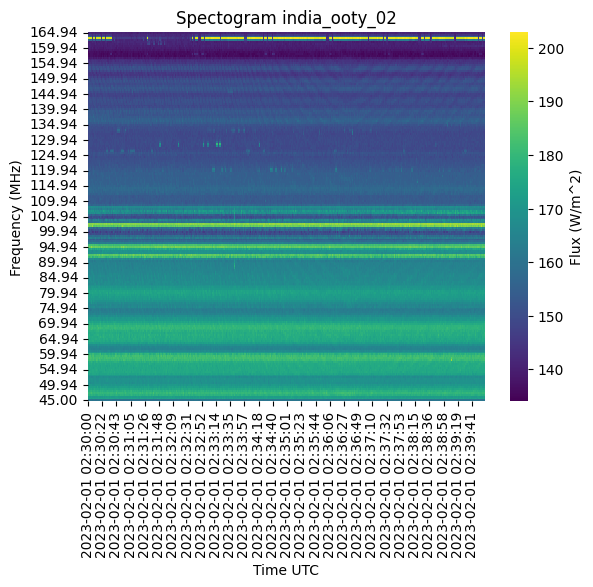

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_spectogram(spectogram, sunflare_type=None):
    spectogram = spectogram.copy()
    spectogram.index = spectogram.index.strftime("%Y-%m-%d %H:%M:%S")
    spectogram.columns = [f"{col:.2f}" for col in spectogram.columns]
    ax = sns.heatmap(spectogram.T, cmap="viridis", cbar_kws={"label": "Flux (W/m^2)"})
    title = f'Spectogram {spectogram.attrs["instrument"]}'
    if sunflare_type is not None:
        title += f". Sunflaretype: {sunflare_type}"
    plt.title(title)
    plt.ylabel("Frequency (MHz)")
    plt.xlabel("Time UTC")
    plt.show()
plot_spectogram(df_spec)

In [ ]:
df_spec.index.strftime("%Y-%m-%d %H:%M:%S").is_monotonic_increasing 

False

In [ ]:
df_spec.index.strftime("%Y-%m-%d %H:%M:%S")

Index(['2023-02-01 02:30:00', '2023-02-01 02:30:00', '2023-02-01 02:30:01',
       '2023-02-01 02:30:01', '2023-02-01 02:30:01', '2023-02-01 02:30:01',
       '2023-02-01 02:30:02', '2023-02-01 02:30:02', '2023-02-01 02:30:02',
       '2023-02-01 02:30:02',
       ...
       '2023-02-01 02:39:57', '2023-02-01 02:39:58', '2023-02-01 02:39:58',
       '2023-02-01 02:39:58', '2023-02-01 02:39:58', '2023-02-01 02:39:59',
       '2023-02-01 02:39:59', '2023-02-01 02:39:59', '2023-02-01 02:39:59',
       '2023-02-01 02:30:00'],
      dtype='object', name='datetime', length=2399)